# ADS 509 Module 3 Assignment 3.1: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


# Importing Packages

In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
# Function to calculate descriptive statistics
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    # Convert tokens to a single list of tokens
    token = tokens.split()

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(token) for token in tokens)

    if verbose :
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
        # five most common tokens
        counter = Counter(token)
        if num_tokens > 0:
            print(counter.most_common(5))
    
    return ([num_tokens, num_unique_tokens,
             lexical_diversity,
             num_characters])
    
    return(0)

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)

# Function to remove stopwords
def remove_stop(tokens) :
    tokens = [token for token in tokens if token.lower() not in sw]
    
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    tokens = [token.strip() for token in text.split()]
    return(tokens)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [3]:
# Function to find directory
def find_directory(target_dir, start_path='.') :
    
    for root, dirs, files in os.walk(start_path) :
        if target_dir in dirs :
            path = os.path.join(root, target_dir)
            
    return path

In [4]:
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
# Finding the twitter directory
twitter_path = find_directory("twitter")

twitter_data = pd.read_csv(os.path.join(twitter_path, artist_files['cher']),
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(os.path.join(twitter_path, artist_files['robyn']),
                             sep="\t",
                             quoting=3)

twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [8]:
# read in the lyrics here
lyrics_list = []
lyrics_path = find_directory("lyrics")

for artist in os.listdir(lyrics_path) :
    artist_path = os.path.join(lyrics_path, artist)

    # Check if it is a directory
    if os.path.isdir(artist_path) :
        for filename in os.listdir(artist_path) :
            
            if filename.endswith('.txt') :
                title = filename.split('_')[1].replace(".txt", "")
                
                file_path = os.path.join(artist_path, filename)
                lyrics = open(file_path, 'r').read()
                
                lyrics_list.append([artist, title, lyrics])
                
lyrics_data = pd.DataFrame(lyrics_list, columns=['artist', 'song_title', 'lyrics'])

In [9]:
lyrics_data.head()

,artist,song_title,lyrics
0,cher,88degrees,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n..."
1,cher,adifferentkindoflovesong,"""A Different Kind Of Love Song""\n\n\n\nWhat if..."
2,cher,afterall,"""After All""\n\n\n\nWell, here we are again\nI ..."
3,cher,again,"""Again""\n\n\n\nAgain evening finds me at your ..."
4,cher,alfie,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [10]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [11]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [12]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
124421,robyn,🧜🏼‍♀️🐉 ~ smoke some for ya nerve 🌿💨 plant love...,"[🧜🏼‍♀️🐉, smoke, ya, nerve, 🌿💨, plant, lovermus..."
17382,robyn,Love Love Love 💞I love you all🌍🌎🌏✨💞✌,"[love, love, love, 💞i, love, all🌍🌎🌏✨💞✌]"
1483292,cher,🎙🔊🎶 Always Playing Music ☠️🎧🤘🏼,"[🎙🔊🎶, always, playing, music, ☠️🎧🤘🏼]"
1055542,cher,Cinematographer.📽🎞Eye shoot people for a livin...,"[cinematographer📽🎞eye, shoot, people, living🎼c..."
645771,cher,"Vem, vamos além! ♓️🌻🦄","[vem, vamos, além, ♓️🌻🦄]"
102924,cher,"🌈GAY(He/Him)❤️ Viciado em séries, fã de Spice ...","[🌈gayhehim❤️, viciado, em, séries, fã, de, spi..."
886128,cher,#BLM #AbolishICE 🏳️‍🌈 UTD ’23 He/Him,"[#blm, #abolishice, 🏳️‍🌈, utd, ’23, hehim]"
2116549,cher,Queen of the Harpies 👑,"[queen, harpies, 👑]"
201269,robyn,I think a feel you I for ever you mint I I lov...,"[think, feel, ever, mint, love, love, love, mu..."
2320764,cher,25 ANOS. Louco por jogos. Fã da maior organiza...,"[25, anos, louco, por, jogos, fã, da, maior, o..."


In [13]:
# After tokenization and normalization
lyrics_data

,artist,song_title,lyrics,tokens,num_tokens
0,cher,88degrees,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n...","[88, degrees, stuck, la, aint, got, friends, h...",182
1,cher,adifferentkindoflovesong,"""A Different Kind Of Love Song""\n\n\n\nWhat if...","[different, kind, love, song, world, crazy, sa...",137
2,cher,afterall,"""After All""\n\n\n\nWell, here we are again\nI ...","[well, guess, must, fate, weve, tried, deep, i...",120
3,cher,again,"""Again""\n\n\n\nAgain evening finds me at your ...","[evening, finds, door, ask, could, try, dont, ...",34
4,cher,alfie,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs...","[alfie, whats, alfie, moment, live, whats, sor...",67
...,...,...,...,...,...
415,robyn,wedancetothebeat114528,"""We Dance To The Beat""\n\n\n\nWe dance to the ...","[dance, beat, dance, beat, dance, beat, dance,...",222
416,robyn,wheredidourlovego,"""Where Did Our Love Go""\n\n\n\nThoughts about ...","[love, go, thoughts, thinkin, used, love, stro...",55
417,robyn,whosthatgirl,"""Who's That Girl""\n\n\n\nGood girls are pretty...","[whos, girl, good, girls, pretty, like, time, ...",170
418,robyn,witheveryheartbeat,"""With Every Heartbeat""\n\n\n\nMaybe we could m...","[every, heartbeat, maybe, could, make, right, ...",106


With the data processed, we can now start work on the assignment questions. 

**Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)**

A: One potential improvement to the tokenization process is incorporating lemmatization or stemming to simplify words to their base or root forms. Lemmatization maintains the correct word form based on context while stemming trims prefixes or suffixes to produce a common base. This helps enhance data consistency and model performance by grouping related terms together.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [14]:
# Function to compare descriptive statistics of two corpus
def compare_texts(corpus_1, corpus_2, num_words=10, ratio_cutoff=5) :
    
    results = dict()
    
    # Calculate descriptive statistics of two corpus
    results['corpus_1'] = descriptive_stats(corpus_1)
    results['corpus_2'] = descriptive_stats(corpus_2)
    
    return results

In [15]:
corpus_1 = lyrics_data['lyrics'][lyrics_data['artist'] == "cher"]
corpus_2 = lyrics_data['lyrics'][lyrics_data['artist'] == "robyn"]

In [16]:
# calls to compare two corpus
compare_texts(" ".join(corpus_1), " ".join(corpus_2), num_words=5)

There are 348947 tokens in the data.
There are 88 unique tokens in the data.
There are 348947 characters in the data.
The lexical diversity is 0.000 in the data.
[('I', 2649), ('you', 2211), ('the', 2131), ('to', 1534), ('a', 1230)]
There are 148081 tokens in the data.
There are 92 unique tokens in the data.
There are 148081 characters in the data.
The lexical diversity is 0.001 in the data.
[('you', 1216), ('I', 831), ('the', 811), ('me', 659), ('to', 640)]


{'corpus_1': [348947, 88, 0.00025218729491871257, 348947],
 'corpus_2': [148081, 92, 0.0006212815958833341, 148081]}

**Q: what observations do you make about these data?**

A: Based on the above results, Cher's lyrics contain a higher number of tokens and characters compared to Robyn's lyrics. The most frequent words, including stopwords, were identified as "I", "you", "the", "to", and "a" for Cher, and "you", "I", "the", "me", and "to" for Robyn.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [17]:
# Function to find tokens that appear at least 5 times in the corpora
def find_tokens(corpus_list, min_count=5) :
    
    token_counts = {}
    
    # Initialize the vectorizer
    vectorizer = CountVectorizer()
    for i, corpus in enumerate(corpus_list) :
        
        # Join all songs in the corpus
        corpus_text = ' '.join(corpus)
        
        # Transform the text into matrix of token counts
        X = vectorizer.fit_transform([corpus_text])
        
        # Token names and their counts
        words = vectorizer.get_feature_names_out()
        counts = X.toarray().flatten()
        
        # Filter first 10 tokens that appear 5 times
        min_tokens = [token for token, count in zip(words, counts) 
                           if count >= min_count][:10]
        
        # Store the tokens in a dictionary
        token_counts[f'corpus_{i+1}'] = min_tokens
        
    return token_counts

In [18]:
lyrics_corpus = [corpus_1, corpus_2]

n = 5
min_lyrics_tokens = find_tokens(lyrics_corpus, n)

for corpus, tokens in min_lyrics_tokens.items() :
    print(f"Tokens that appear atleast {n} times in {corpus}:")
    print(tokens,'\n')

Tokens that appear atleast 5 times in corpus_1:
['88', 'about', 'above', 'across', 'affair', 'affection', 'afraid', 'after', 'again', 'against'] 

Tokens that appear atleast 5 times in corpus_2:
['10', '22', '4x', '88', 'about', 'act', 'acts', 'afraid', 'again', 'agree'] 



In [19]:
# Function to find the top 10 tokens in each corpus
def find_top_tokens(corpus_list, top_n=10) :
    
    results = {}
    
    # Initialize the vectorizer
    vectorizer = CountVectorizer()
    for i, corpus in enumerate(corpus_list) :
            
        # Transform the document into matrix
        X = vectorizer.fit_transform([corpus])
    
        # Get the feature names (tokens)
        tokens = vectorizer.get_feature_names_out()
        # Get the token counts
        token_counts = X.toarray().flatten()
    
        tokens_df = pd.DataFrame({'token': tokens, 'count': token_counts})
    
        # Sort by count and selecting top 10 tokens
        top_tokens_df = tokens_df.sort_values(by='count', ascending=False).head(top_n)
        
        results[f'corpus_{i+1}'] = top_tokens_df
    
    return results

In [20]:
corpus_3 = twitter_data['description'][twitter_data['artist'] == "cher"]
corpus_4 = twitter_data['description'][twitter_data['artist'] == "robyn"]

corpus_list = [corpus_1, corpus_2, corpus_3, corpus_4]

# Convert each corpus Series object to a string
corpus_list = [corpus.to_string(index=False) for corpus in corpus_list]

In [22]:
top_n = 10
top_tokens = find_top_tokens(corpus_list, top_n)

for corpus, tokens in top_tokens.items() :
    print(f"Top tokens for {corpus}:")
    print(tokens)
    print('\n')

Top tokens for corpus_1:
    token  count
786   the     92
894   you     81
505    ni     62
400    me     47
380  love     45
808    to     43
605    of     33
318    it     31
311    in     28
436    my     24


Top tokens for corpus_2:
    token  count
364   you     32
208    ni     19
161    me     17
315   the     16
324    to     13
174    my     12
129    it     12
121    in     12
71    don      9
348  what      8


Top tokens for corpus_3:
       token    count
303911   nan  1994065
34786    and   269118
431305   the   219473
438315    to   185667
319687    of   180948
300673    my   146133
265220  love   138795
212889    in   125520
220001    is   120312
485039   you    95303


Top tokens for corpus_4:
        token   count
73505     nan  168355
6497      and   21172
107108    the   19981
77492      of   14242
51575      in   12100
108728     to   11923
72210   music    9963
53714      is    9907
72712      my    9600
120892    you    7953




**Q: What are some observations about the top tokens? Do you notice any interesting items on the list?**

A: The analysis of the top tokens across all four corpora reveals the presence of several common words, such as "the," "you," and "my," which exhibit both high frequency and relevance within the contexts of lyrics and Twitter data. Moreover, the Twitter descriptions for both artists contain null values indicating a potential gap in the artists' engagement strategies on social media.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [23]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

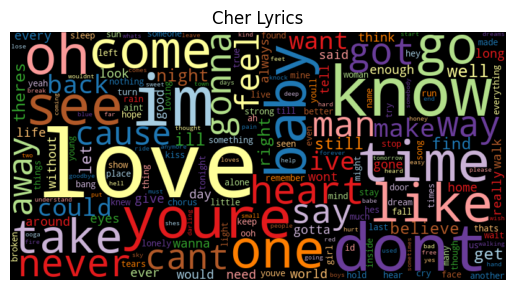

In [24]:
# Word clouds for Corpus 1 
corpus_1_freq = count_words(lyrics_data[lyrics_data['artist'] == "cher"])
wordcloud(corpus_1_freq['freq'], title = "Cher Lyrics")

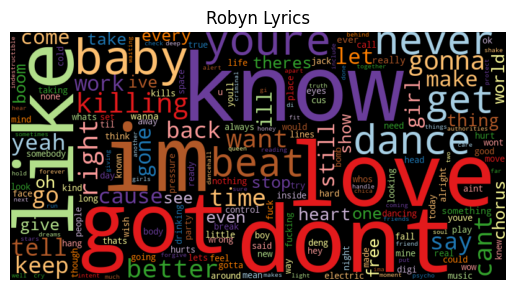

In [25]:
# Word clouds for Corpus 2 
corpus_2_freq = count_words(lyrics_data[lyrics_data['artist'] == "robyn"])
wordcloud(corpus_2_freq['freq'], title = "Robyn Lyrics")

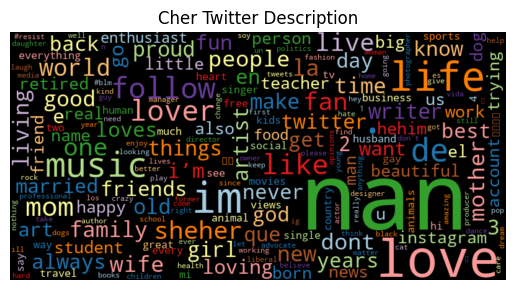

In [26]:
# Word clouds for Corpus 3 
corpus_3_freq = count_words(twitter_data[twitter_data['artist'] == "cher"])
wordcloud(corpus_3_freq['freq'], title = "Cher Twitter Description")

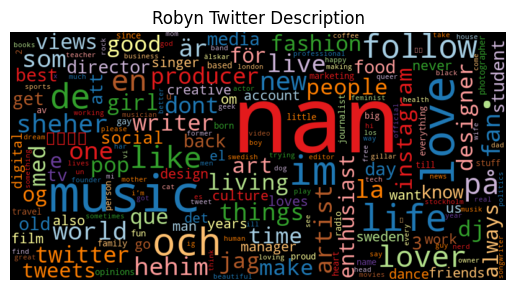

In [27]:
# Word clouds for Corpus 4
corpus_4_freq = count_words(twitter_data[twitter_data['artist'] == "robyn"])
wordcloud(corpus_4_freq['freq'], title = "Robyn Twitter Description")

**Q: What observations do you have about these (relatively straightforward) wordclouds?**

A: The word cloud visually depicts the frequency of words, with those that occur more often displayed in larger font sizes and bold type, allowing them to stand out prominently. In contrast, less frequent words are shown in smaller sizes and regular font-weight, diminishing their visual impact. This design enables viewers to easily discern the primary themes and key vocabulary within the text, as the more significant words dominate the overall visual composition.